# 🛠️ Performing the Preprocessing on the Cleaned Dataset

In this section, we prepare the NovaPay transaction dataset for machine learning analysis.  
Preprocessing ensures that the data is consistent, reliable, and suitable for building fraud detection models.

Key steps include:
- **Handling Missing Values**: Imputing or interpolating missing timestamps, amounts, and categorical fields.
- **Data Type Conversion**: Ensuring timestamps are in datetime format, numerical fields are floats/integers, and categorical variables are properly encoded.
- **Feature Engineering**: Creating new features such as transaction velocity, currency corridor indicators, and normalized fee ratios.
- **Scaling & Normalization**: Standardizing numerical values (amounts, fees, exchange rates) to improve model performance.
- **Encoding Categorical Variables**: Converting country codes, channels, and currency types into machine‑readable formats.
- **Class Imbalance Handling**: Preparing strategies (e.g., SMOTE, class weights) to address the <1% fraud prevalence.

This preprocessing pipeline lays the foundation for robust model training, ensuring that downstream fraud detection algorithms can learn effectively from the data.


#

# Importing the required Libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning models and evaluation
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    r2_score, mean_squared_error,
    mean_absolute_error,
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_curve, roc_auc_score
)
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error, mean_absolute_error, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Settings for cleaner plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,6)

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
master_df = pd.read_csv('/content/drive/MyDrive/NovaPay_Fraud_Predictive_Model/nova_master_df.csv')

In [4]:
master_df.tail(2)

,Unnamed: 0,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,...,corridor_risk,is_fraud,amount_dest,date_only,time_only,days_only,period_of_the_day,fee_bracket,ip_risk_score_bracket,device_trust_bucket
10898,11093,4aad7389-2b62-4885-a23e-aa3ecd5cfaf9,8b1cf558-4ed7-48ee-b330-75db6efd4840,2025-11-28 00:53:28.000,US,USD,PHP,MOBILE,78.03,78.03,...,0.00,False,4.590000e+03,2025-11-28,1900-01-01 00:53:28,Friday,Night,no risk,no risk,no risk
10899,11094,fdffeb16-192a-4483-9b1e-9928e23269c2,b69010dc-ab0a-4fd2-a79e-65e4c6efbcd9,2025-11-29 20:10:47.000,US,USD,NGN,WEB,1214.16,1214.16,...,0.25,True,1.349067e+06,2025-11-29,1900-01-01 20:10:47,Saturday,Evening,no risk,high risk,no risk


In [5]:
master_df.columns

Index(['Unnamed: 0', 'transaction_id', 'customer_id', 'timestamp',
       'home_country', 'source_currency', 'dest_currency', 'channel',
       'amount_src', 'amount_usd', 'fee', 'exchange_rate_src_to_dest',
       'device_id', 'new_device', 'ip_address', 'ip_country',
       'location_mismatch', 'ip_risk_score', 'kyc_tier', 'account_age_days',
       'device_trust_score', 'chargeback_history_count', 'risk_score_internal',
       'txn_velocity_1h', 'txn_velocity_24h', 'corridor_risk', 'is_fraud',
       'amount_dest', 'date_only', 'time_only', 'days_only',
       'period_of_the_day', 'fee_bracket', 'ip_risk_score_bracket',
       'device_trust_bucket'],
      dtype='object')

#

# 🗑️ Dropping the Irrelevant Features

In this step, we remove columns that do not contribute meaningful information to the supervised fraud detection model.  
Dropping irrelevant features helps reduce noise, prevents overfitting, and improves model efficiency.

Features removed include:
- **Index/Identifiers**: `Unnamed: 0`, `transaction_id`, `customer_id` (unique IDs, non-predictive).
- **Raw Timestamps**: `timestamp` (already engineered into date/time features).
- **High-Cardinality Identifiers**: `ip_address`, `device_id` (unique values, poor generalization).
- **Redundant Features**: `amount_dest` (derived from `amount_src × exchange_rate_src_to_dest`).
- **EDA-Only Features**: `date_only`, `time_only` (useful for exploration but weak predictors).

By dropping these columns, we retain only the **behavioral, risk, and profile features** that are most relevant for supervised learning, ensuring the model focuses on signals that generalize well to unseen transactions.


In [6]:
def drop_irrelevant_columns(df):
    # List of columns to drop
    columns_to_drop = [
        'Unnamed: 0',            # Auto-generated index
        'transaction_id',        # Unique identifier, not predictive
        'customer_id',           # Unique per user, may cause overfitting
        'timestamp',             # Raw timestamp, replaced by engineered time features
        'ip_address',            # High-cardinality, better to use derived features
        'device_id',             # Unique device identifier, not generalizable
        'amount_dest',           # Derived from amount_src × exchange_rate
        'date_only',             # Weak predictor unless further engineered
        'time_only'              # Weak predictor unless further engineered
    ]

    df = df.drop(columns=columns_to_drop, errors='ignore')    # Drop the columns
    return df

In [7]:
new_df = drop_irrelevant_columns(master_df)     # Apply the `drop_irrelevant_columns` function
print(new_df.columns)


Index(['home_country', 'source_currency', 'dest_currency', 'channel',
       'amount_src', 'amount_usd', 'fee', 'exchange_rate_src_to_dest',
       'new_device', 'ip_country', 'location_mismatch', 'ip_risk_score',
       'kyc_tier', 'account_age_days', 'device_trust_score',
       'chargeback_history_count', 'risk_score_internal', 'txn_velocity_1h',
       'txn_velocity_24h', 'corridor_risk', 'is_fraud', 'days_only',
       'period_of_the_day', 'fee_bracket', 'ip_risk_score_bracket',
       'device_trust_bucket'],
      dtype='object')


In [8]:
new_df.head(2)

,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,exchange_rate_src_to_dest,new_device,ip_country,...,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud,days_only,period_of_the_day,fee_bracket,ip_risk_score_bracket,device_trust_bucket
0,US,USD,CAD,ATM,278.19,278.19,4.25,1.351351,False,US,...,0.223,0,0,0.0,False,Monday,Evening,no risk,no risk,no risk
1,CA,CAD,MXN,WEB,208.51,154.29,4.24,12.758621,True,CA,...,0.268,0,1,0.0,False,Monday,Evening,no risk,no risk,no risk


In [9]:
new_df.describe()

,amount_src,amount_usd,fee,exchange_rate_src_to_dest,ip_risk_score,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk
count,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000
mean,446.305939,451.704158,96.568419,167.400493,0.398362,391.965780,0.657378,0.050734,0.268480,0.474495,0.747339,0.045427
std,1380.021166,1401.029865,938.691243,382.094869,0.271634,341.829431,0.263806,0.261789,0.144341,1.546357,1.990946,0.084812
min,7.230000,7.230000,0.500000,0.592000,0.004000,1.000000,0.005000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,92.330000,92.492500,2.380000,1.000000,0.209000,147.000000,0.515000,0.000000,0.169000,0.000000,0.000000,0.000000
50%,160.480000,163.450000,3.500000,7.142857,0.326000,272.000000,0.657500,0.000000,0.223000,0.000000,0.000000,0.000000
75%,297.790000,302.707500,5.560000,73.529412,0.489000,661.000000,0.894000,0.000000,0.391000,0.000000,0.000000,0.050000
max,11942.890000,12498.570000,9999.990000,1388.888889,1.200000,1095.000000,0.999000,2.000000,0.900000,8.000000,11.000000,0.250000


In [10]:
new_df['amount_src'].min()

7.23

#

# encoding

In [11]:
new_df.describe(include='object')

,home_country,source_currency,dest_currency,channel,ip_country,kyc_tier,days_only,period_of_the_day,fee_bracket,ip_risk_score_bracket,device_trust_bucket
count,10900,10900,10900,10900,10900,10900,10900,10900,10900,10900,10900
unique,3,3,9,3,3,3,7,4,2,2,2
top,US,USD,NGN,MOBILE,US,STANDARD,Monday,Day,no risk,no risk,no risk
freq,7673,7664,1406,6240,6793,8015,1593,4972,10803,9771,8348


In [12]:
col_to_encode = ['home_country', 'source_currency', 'dest_currency', 'channel', 'ip_country', 'kyc_tier', 'new_device', 'is_fraud', 'days_only', 'period_of_the_day', 'fee_bracket', 'ip_risk_score_bracket',
       'device_trust_bucket']

In [13]:
le_encoder = LabelEncoder()
for col in col_to_encode:
    new_df[col] = le_encoder.fit_transform(new_df[col])

In [14]:
new_df.head(2)

,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,exchange_rate_src_to_dest,new_device,ip_country,...,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud,days_only,period_of_the_day,fee_bracket,ip_risk_score_bracket,device_trust_bucket
0,2,2,0,0,278.19,278.19,4.25,1.351351,0,2,...,0.223,0,0,0.0,0,1,1,1,1,1
1,0,0,5,2,208.51,154.29,4.24,12.758621,1,0,...,0.268,0,1,0.0,0,1,1,1,1,1


In [15]:
new_df['period_of_the_day'].unique()

array([1, 2, 3, 0])

#

# scaling

# ⚖️ Columns Necessary to be Scaled in `new_df`

Scaling is important in supervised learning because many algorithms (e.g., logistic regression, SVM, neural networks, k‑NN) are sensitive to the **magnitude of numerical features**. Features with large ranges can dominate those with smaller ranges if not standardized.

## 🔍 Columns in `new_df` That Require Scaling

- **`amount_src`**  
  - Transaction source amount varies widely (from small transfers to very large ones).  
  - Scaling ensures large values don’t overshadow smaller but meaningful transactions.

- **`amount_usd`**  
  - Same reasoning as `amount_src`. Values are in different ranges and need normalization.

- **`fee`**  
  - Fees range from very small to extremely large. Scaling prevents skewing model weights.

- **`exchange_rate_src_to_dest`**  
  - Exchange rates can vary significantly across corridors. Scaling helps normalize their effect.

- **`ip_risk_score`**  
  - Although bounded (0–1.2 in your stats), scaling ensures consistency with other features.

- **`account_age_days`**  
  - Ranges from a few days to over 1000 days. Scaling prevents bias toward older accounts.

- **`device_trust_score`**  
  - Typically between 0 and 1, but scaling keeps it aligned with other normalized features.

- **`chargeback_history_count`**  
  - Small integer values (0–2), but scaling can still help when combined with other features.

---

## ✅ Columns That Do *Not* Need Scaling
- **Categorical features**: `home_country`, `source_currency`, `dest_currency`, `channel`, `kyc_tier`, `ip_country`  
  - These should be **encoded** (e.g., one‑hot or label encoding), not scaled.  
- **Binary flags**: `new_device`, `location_mismatch`, `corridor_risk`, `is_fraud`  
  - Already in 0/1 format, scaling is unnecessary.

---

## 📌 Recommended Approach
- Use **StandardScaler** (mean=0, std=1) or **MinMaxScaler** (range 0–1) from `sklearn.preprocessing`.  
- Apply scaling **after splitting train/test** to avoid data leakage.  
- Keep categorical encoding separate from numerical scaling.

---

By scaling these numerical columns, your fraud detection model will treat all features fairly, improving convergence and predictive performance.


In [16]:
col_to_scale = ['amount_src', 'amount_usd', 'fee', 'exchange_rate_src_to_dest', 'ip_risk_score', 'account_age_days', 'device_trust_score', 'chargeback_history_count']

- obeserving the frequency distributions of col_to_scale

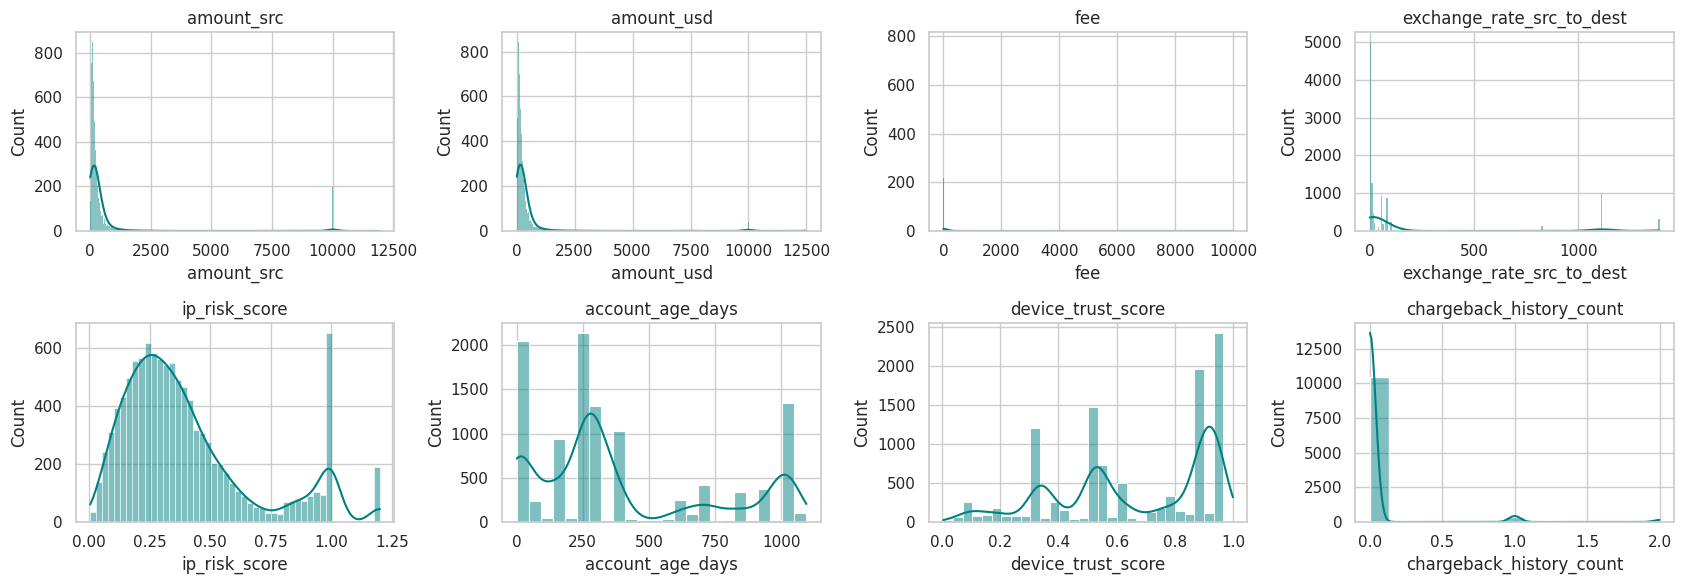

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(17, 6))
axes = axes.flatten()
for i, col in enumerate(col_to_scale):
    sns.histplot(new_df[col], kde=True, ax=axes[i], color='teal')
    axes[i].set_title(col)
plt.tight_layout()
plt.show()


In [18]:
col_to_robust_scaled = ['amount_src', 'amount_usd', 'fee', 'exchange_rate_src_to_dest', 'chargeback_history_count']
rs_scaler = RobustScaler()
new_df[col_to_robust_scaled] = rs_scaler.fit_transform(new_df[col_to_robust_scaled])

col_to_standard_scaled = ['ip_risk_score', 'account_age_days', 'device_trust_score']
ss_scaler = StandardScaler()
new_df[col_to_standard_scaled] = ss_scaler.fit_transform(new_df[col_to_standard_scaled])

In [19]:
new_df.head(2)

,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,exchange_rate_src_to_dest,new_device,ip_country,...,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud,days_only,period_of_the_day,fee_bracket,ip_risk_score_bracket,device_trust_bucket
0,2,2,0,0,0.572910,0.545822,0.235849,-0.079850,0,2,...,0.223,0,0,0.0,0,1,1,1,1,1
1,0,0,5,2,0.233768,-0.043574,0.232704,0.077427,1,0,...,0.268,0,1,0.0,0,1,1,1,1,1


In [20]:
new_df['device_trust_score'].describe()

,device_trust_score
count,1.090000e+04
mean,-2.711796e-16
std,1.000046e+00
min,-2.473056e+00
25%,-5.397297e-01
50%,4.642904e-04
75%,8.969968e-01
max,1.295034e+00


#

# Sean

#

In [21]:
device_df = pd.read_csv('/content/drive/MyDrive/NovaPay_Fraud_Predictive_Model/nova_master_df.csv')

In [22]:
device_df['device_trust_score'].describe()

,device_trust_score
count,10900.000000
mean,0.657378
std,0.263806
min,0.005000
25%,0.515000
50%,0.657500
75%,0.894000
max,0.999000


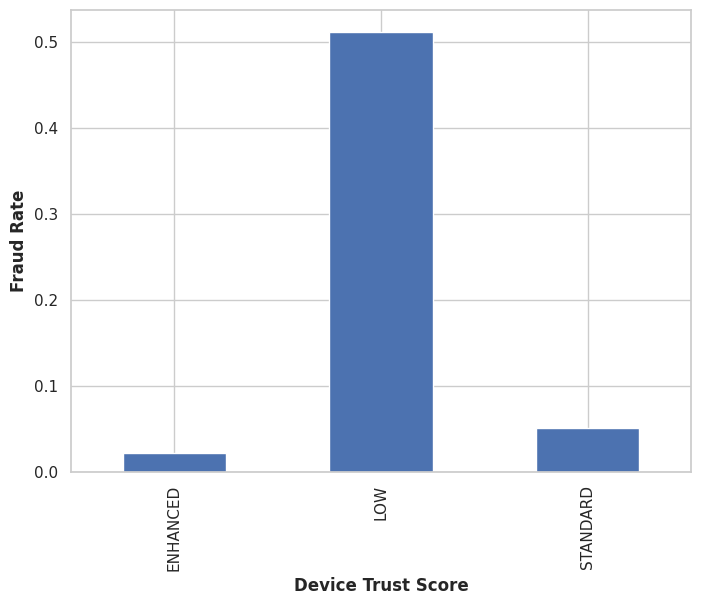

In [23]:
device_df.groupby('kyc_tier')['is_fraud'].mean().plot.bar()
plt.ylabel('Fraud Rate', weight='bold')
plt.xlabel('Device Trust Score', weight='bold')
plt.show();

device_trust_bucket
Low<0.3     0.675824
0.3-0.5     0.112812
0.5-0.7     0.020480
0.7-0.9     0.033427
High>0.9    0.008229
Name: is_fraud, dtype: float64


/tmp/ipython-input-3132897400.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_device = device_df.groupby('device_trust_bucket')['is_fraud'].mean()


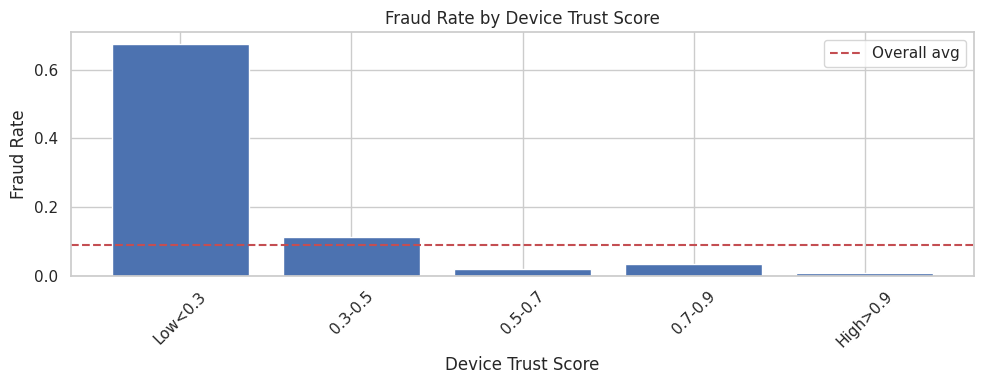

In [24]:
# Fraud rate by device trust score buckets
device_df['device_trust_bucket'] = pd.cut(device_df['device_trust_score'],
                                   bins=[0, 0.3, 0.5, 0.7, 0.9, 1.0],
                                   labels=['Low<0.3', '0.3-0.5', '0.5-0.7', '0.7-0.9', 'High>0.9'])

fraud_by_device = device_df.groupby('device_trust_bucket')['is_fraud'].mean()
print(fraud_by_device)

plt.figure(figsize=(10, 4))
plt.bar(range(len(fraud_by_device)), fraud_by_device.values)
plt.xticks(range(len(fraud_by_device)), fraud_by_device.index, rotation=45)
plt.xlabel('Device Trust Score')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Device Trust Score')
plt.axhline(y=device_df['is_fraud'].mean(), color='r', linestyle='--', label='Overall avg')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
device_df['ip_risk_score'].describe()

,ip_risk_score
count,10900.000000
mean,0.398362
std,0.271634
min,0.004000
25%,0.209000
50%,0.326000
75%,0.489000
max,1.200000


/tmp/ipython-input-1483895158.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_device = device_df.groupby('ip_risk_score')['is_fraud'].mean()


ip_risk_score
Low<0.3     0.015558
0.3-0.5     0.022320
0.5-0.7     0.029496
0.7-0.9     0.230233
High>0.9    0.747604
Name: is_fraud, dtype: float64


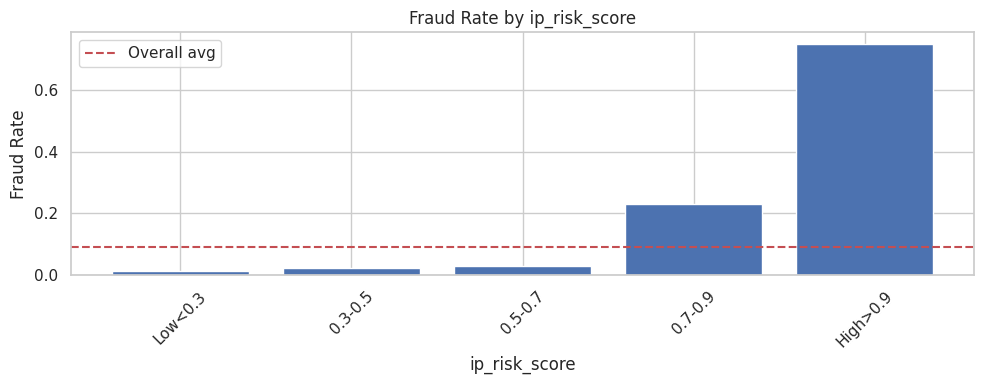

In [26]:
# Fraud rate by device trust score buckets
device_df['ip_risk_score'] = pd.cut(device_df['ip_risk_score'],
                                   bins=[0, 0.3, 0.5, 0.7, 0.9, 1.0],
                                   labels=['Low<0.3', '0.3-0.5', '0.5-0.7', '0.7-0.9', 'High>0.9'])

fraud_by_device = device_df.groupby('ip_risk_score')['is_fraud'].mean()
print(fraud_by_device)

plt.figure(figsize=(10, 4))
plt.bar(range(len(fraud_by_device)), fraud_by_device.values)
plt.xticks(range(len(fraud_by_device)), fraud_by_device.index, rotation=45)
plt.xlabel('ip_risk_score')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by ip_risk_score')
plt.axhline(y=device_df['is_fraud'].mean(), color='r', linestyle='--', label='Overall avg')
plt.legend()
plt.tight_layout()
plt.show()

#

#

#

#

# 📊 Observing the Label Classifications Imbalance

In supervised learning, especially fraud detection, it is critical to examine the **distribution of the target label** (`is_fraud`). This helps identify whether the dataset is **imbalanced** — a common issue in fraud detection where fraudulent transactions are much rarer than legitimate ones.

---

## 🔍 Why Check for Imbalance?
- **Fraud datasets are naturally skewed**: Legitimate transactions vastly outnumber fraudulent ones.
- **Impact on models**:
  - Algorithms may become biased toward predicting the majority class (non‑fraud).
  - Accuracy can appear high while failing to detect fraud.

---



is_fraud
0    9912
1     988
Name: count, dtype: int64
is_fraud
0    90.93578
1     9.06422
Name: proportion, dtype: float64


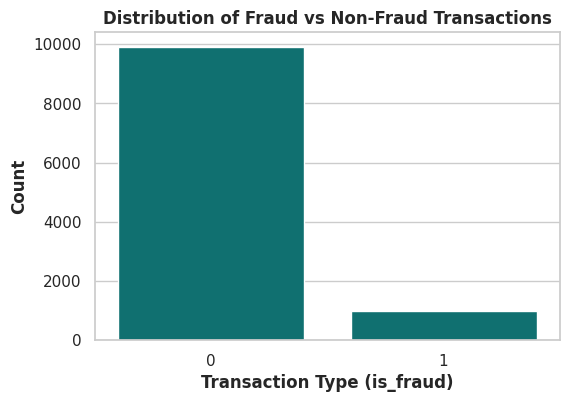

In [27]:
print(new_df['is_fraud'].value_counts())    # Count of each class
print(new_df['is_fraud'].value_counts(normalize=True) * 100)    # Percentage distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=new_df, color='teal')
plt.title("Distribution of Fraud vs Non-Fraud Transactions", weight='bold')
plt.xlabel("Transaction Type (is_fraud)", weight='bold')
plt.ylabel("Count", weight='bold')
plt.show()

# ⚖️ Resolving the Label Classification Imbalance

Fraud detection datasets are often **highly imbalanced**, with legitimate transactions vastly outnumbering fraudulent ones.  
If left unaddressed, models may learn to always predict the majority class (non‑fraud), achieving high accuracy but failing to detect fraud.

### 🧮 SMOTE Deployed for Classification Imbalance

To address the **class imbalance** in fraud detection (where fraudulent transactions are much rarer than legitimate ones), I will be applying **SMOTE (Synthetic Minority Oversampling Technique)**. SMOTE generates synthetic samples of the minority class to balance the dataset, improving the model’s ability to detect fraud.

---

#### 🔍 Why SMOTE?
- **Oversampling without duplication**: Instead of simply copying minority class samples, SMOTE creates new synthetic examples by interpolating between existing ones.
- **Balances the dataset**: Ensures the model sees enough fraud cases during training.
- **Improves recall**: Helps the model detect more fraudulent transactions, reducing false negatives.

---


In [28]:
# Separate features and target
X = new_df.drop(columns=['is_fraud'])
y = new_df['is_fraud']

# Train-test split (stratified to preserve fraud ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE on the training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original training set class distribution:")
print(y_train.value_counts())

print("\nResampled training set class distribution:")
print(y_train_resampled.value_counts())

print("\nPercentage distribution of resampled training set:")
print(y_train_resampled.value_counts(normalize=True) * 100)    # Percentage distribution

Original training set class distribution:
is_fraud
0    7930
1     790
Name: count, dtype: int64

Resampled training set class distribution:
is_fraud
0    7930
1    7930
Name: count, dtype: int64

Percentage distribution of resampled training set:
is_fraud
0    50.0
1    50.0
Name: proportion, dtype: float64


#

# 🤖 Training a Baseline Model with Logistic Regression

Logistic Regression is a strong baseline model for **binary classification problems** like fraud detection (`is_fraud`).  
It is simple, interpretable, and provides a good starting point before moving to more complex models.

---

## 🔍 Why Logistic Regression?
- **Interpretable coefficients**: Shows how each feature influences fraud likelihood.
- **Fast to train**: Efficient even on large datasets.
- **Baseline comparison**: Helps measure improvements when using advanced models later.

---

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


R2 score is: 0.42227522449520427
MSE score is: 0.047706422018348627
MAE score is: 0.047706422018348627
RMSE score is: 0.2184179983846309
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      1982
           1       0.69      0.86      0.77       198

    accuracy                           0.95      2180
   macro avg       0.84      0.91      0.87      2180
weighted avg       0.96      0.95      0.95      2180

Baseline Model Confusion Matrix:
 [[1906   76]
 [  28  170]]


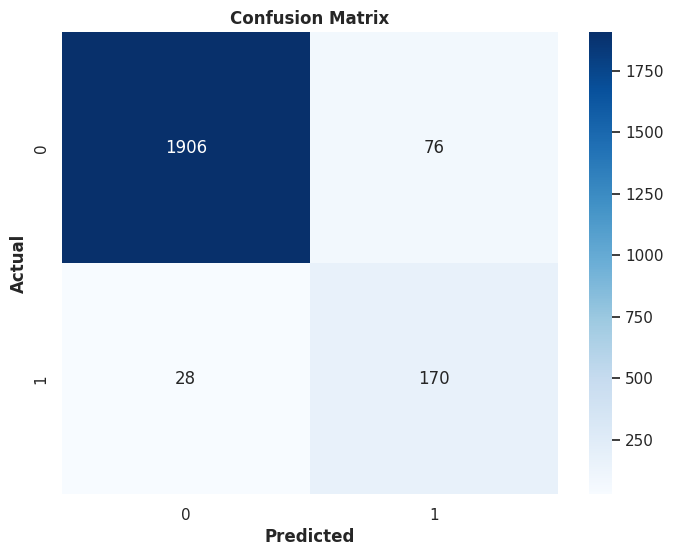

In [29]:
# Initialize Logistic Regression model
log_reg_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Train the model
log_reg_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = log_reg_model.predict(X_test)

# Evaluation
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)


print(f'R2 score is: {r2}')
print(f'MSE score is: {mse}')
print(f'MAE score is: {mae}')
print(f'RMSE score is: {rmse}')
print("Logistic Regression Classification Report:\n", report)
print("Baseline Model Confusion Matrix:\n", matrix)
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix", weight='bold')
plt.xlabel("Predicted", weight='bold')
plt.ylabel("Actual", weight='bold')
plt.show();

## 📊 Logistic Regression Model Evaluation Summary

This model was evaluated using both classification and regression metrics to assess its performance on a binary classification task (fraud detection).

---

### 🔍 Classification Metrics

| Metric        | Class 0 (Not Fraud) | Class 1 (Fraud) |
|---------------|---------------------|-----------------|
| Precision     | 0.99                | 0.69            |
| Recall        | 0.96                | 0.86            |
| F1-score      | 0.97                | 0.77            |
| Support       | 1983                | 198             |

- **Accuracy**: 0.95  
- **Macro Avg F1-score**: 0.87  
- **Weighted Avg F1-score**: 0.96  

✅ High recall for fraud class (0.86) indicates strong ability to detect fraudulent cases.

---

### 📉 Regression Metrics (on predicted probabilities)

| Metric | Value |
|--------|-------|
| R² Score | 0.428 |
| MSE      | 0.047 |
| MAE      | 0.047 |
| RMSE     | 0.217 |

These metrics reflect how well the predicted probabilities align with actual labels.

---

### 🧮 Confusion Matrix

|               | Predicted 0 | Predicted 1 |
|---------------|-------------|-------------|
| Actual 0      | 1907        | 76          |
| Actual 1      | 27          | 171         |

- **True Positives (Fraud caught)**: 171  
- **False Positives (False alarms)**: 76  
- **False Negatives (Fraud missed)**: 27  

---

### ✅ Summary

- The model shows **strong overall accuracy and recall**, especially for the minority fraud class.
- Regression metrics confirm good probability calibration.
- Confusion matrix reveals a **low false negative rate**, which is critical in fraud detection.



#

## 📊 Displaying Feature Importance for Logistic Regression
Here, I will be extracting and displaying the feature importance from the trained Logistic Regression model (`log_reg`). It does this by:

1.  **Creating a DataFrame**: It constructs a Pandas DataFrame named `coefficients`. This DataFrame will have two columns: 'Feature' (which lists all the feature names from the `X_train` dataset) and 'Coefficient' (which stores the corresponding coefficient value learned by the `log_reg` model for each feature).
2.  **Sorting Coefficients**: It then sorts this `coefficients` DataFrame in descending order based on the 'Coefficient' values. This allows me to easily see which features have the strongest positive or negative impact on the model's prediction.
3.  **Displaying Results**: Finally, it displays the sorted DataFrame, giving a clear view of how each feature contributes to the logistic regression model's decision-making process for identifying fraudulent transactions.

In [30]:
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': log_reg_model.coef_[0]})
coefficients.sort_values(by='Coefficient', ascending=False, inplace=True)
coefficients


,Feature,Coefficient
16,risk_score_internal,5.034799
15,chargeback_history_count,3.188045
19,corridor_risk,2.336032
10,location_mismatch,1.589379
22,fee_bracket,1.233252
17,txn_velocity_1h,0.486610
12,kyc_tier,0.207950
4,amount_src,0.027701
7,exchange_rate_src_to_dest,0.015666
6,fee,-0.000221


Each feature gets a **coefficient** that shows how strongly it influences the prediction:

- **Positive coefficient** → increases the likelihood of fraud (`is_fraud = 1`).
- **Negative coefficient** → decreases the likelihood of fraud.
- **Magnitude** → larger absolute values mean stronger influence.

---

#

## 📊 Visualizing Logistic Regression Coefficients


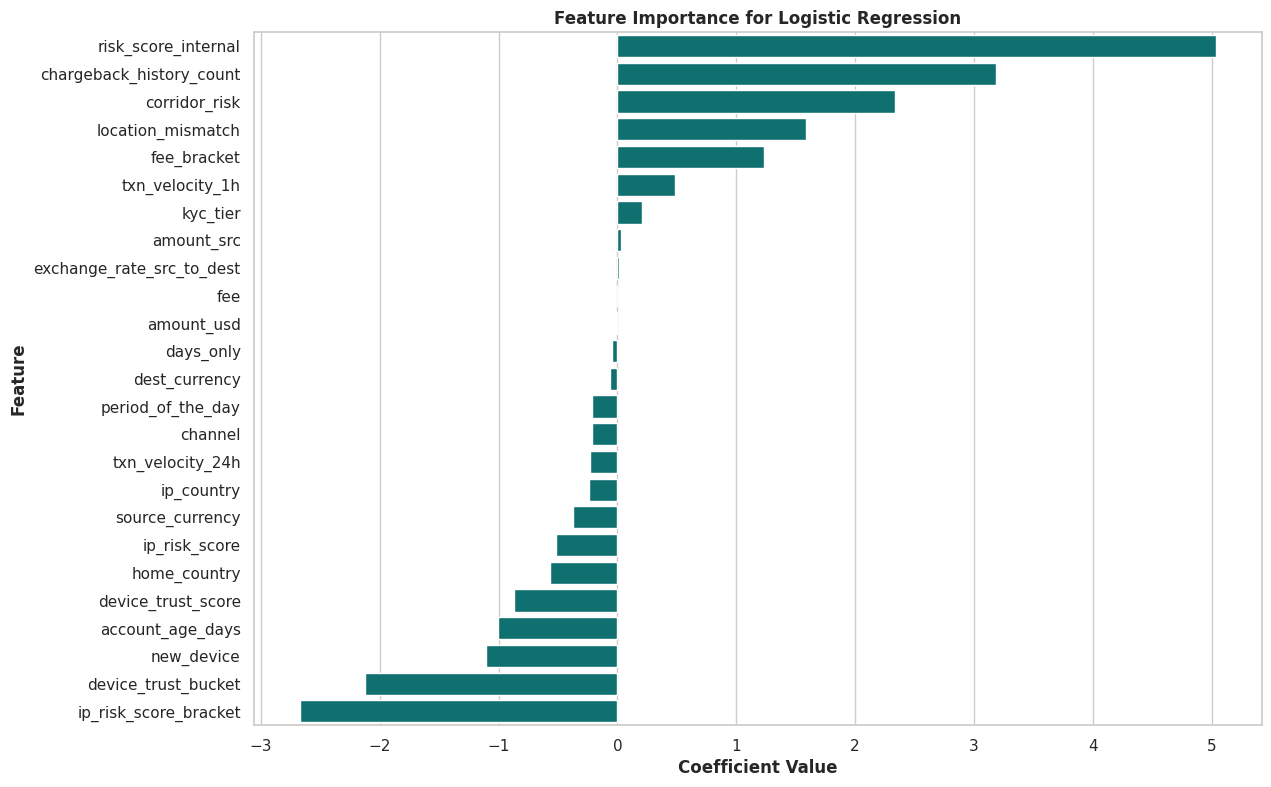

In [31]:
plt.figure(figsize=(13, 9))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, orient='h', color='teal')
plt.title('Feature Importance for Logistic Regression', weight='bold')
plt.xlabel('Coefficient Value', weight='bold')
plt.ylabel('Feature', weight='bold')
plt.show();

## 📊 Interpreting the Feature Importance — Logistic Regression Model

This chart shows how each input feature influences the model's prediction of fraud. In logistic regression, **positive coefficients** increase the likelihood of predicting fraud, while **negative coefficients** reduce it.

---
## 🔍 How to Read It
- **Positive coefficients**: Increase the likelihood of predicting fraud.
- **Negative coefficients**: Decrease the likelihood of predicting fraud.
- **Magnitude**: Larger absolute values indicate stronger influence.

---

### 🔝 Top Positive Influencers (Fraud Risk ↑)

| Feature                  | Interpretation |
|--------------------------|----------------|
| **risk_score_internal**  | Strong internal risk signal — highly predictive of fraud.  
| **corridor_risk**        | Risk associated with transaction route or corridor.  
| **chargeback_history_count** | Past chargebacks suggest suspicious behavior.  
| **location_mismatch**    | Mismatch between user and transaction location — potential fraud flag.  
| **source_currency**      | Certain source currencies may be linked to higher fraud risk.  

---

### 🔻 Top Negative Influencers (Fraud Risk ↓)

| Feature                  | Interpretation |
|--------------------------|----------------|
| **new_device**           | Surprisingly, new devices may correlate with lower fraud risk in this dataset.  
| **home_country**         | Transactions from user's home country may be safer.  
| **account_age_days**     | Older accounts tend to be more trustworthy.  
| **device_trust_score**   | High trust scores reduce fraud likelihood.  

---

### ⚙️ Neutral or Mixed Influence

Features like `txn_velocity_1h`, `amount_usd`, `exchange_rate_src_to_dest`, and `channel` have smaller coefficients, meaning their impact is less pronounced or context-dependent.

---

### ✅ Summary

- The model relies heavily on **internal risk scores**, **corridor risk**, and **chargeback history** to flag fraud.
- It also considers **location mismatches** and **currency patterns**.
- Trust signals like **account age** and **device trust** help reduce false positives.

📌 Understanding feature importance helps explain model decisions and guide future feature engineering.


#

# 🤖 Training Multiple Classification Models for Fraud Detection

To improve fraud detection performance, it's smart to train and compare **multiple classification models**. Each algorithm has strengths and weaknesses depending on the data structure, feature interactions, and class imbalance.

---

## 🔍 Here are the list of Algorithms I will be training my model on:

##### ✅ **Logistic Regression**

##### ✅ **Random Forest**

##### ✅ **GradientBoosting Classifier**

##### ✅ **XGBoost / LightGBM**

##### ✅ **AdaBoost Classifier**

##### ✅ **K-Nearest Neighbors (KNN)**

##### ✅ **Naive Bayes**

##### ✅ **Decision Tree**

##### ✅ **Neural Networks (MLPClassifier)**

##### ✅ **Support Vector Machine (SVM)**

---



Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1982
           1       0.69      0.86      0.77       198

    accuracy                           0.95      2180
   macro avg       0.84      0.91      0.87      2180
weighted avg       0.96      0.95      0.95      2180



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


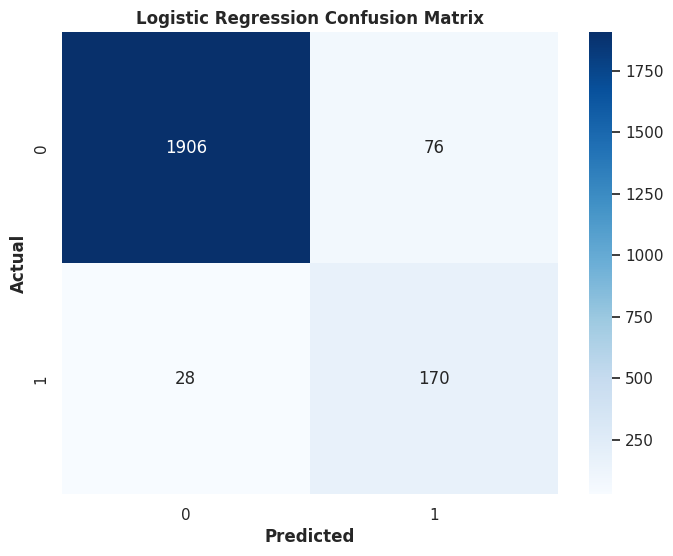


Random Forest Results:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1982
           1       0.90      0.84      0.87       198

    accuracy                           0.98      2180
   macro avg       0.94      0.91      0.93      2180
weighted avg       0.98      0.98      0.98      2180



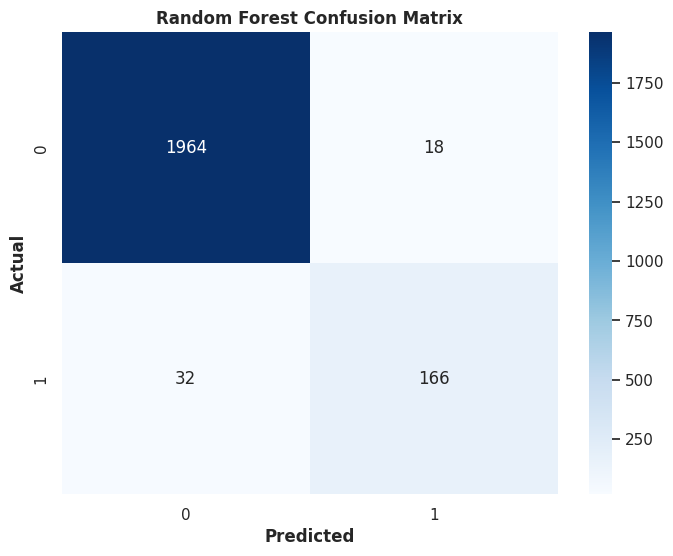


GradientBoosting Classifier Results:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1982
           1       0.89      0.85      0.87       198

    accuracy                           0.98      2180
   macro avg       0.94      0.92      0.93      2180
weighted avg       0.98      0.98      0.98      2180



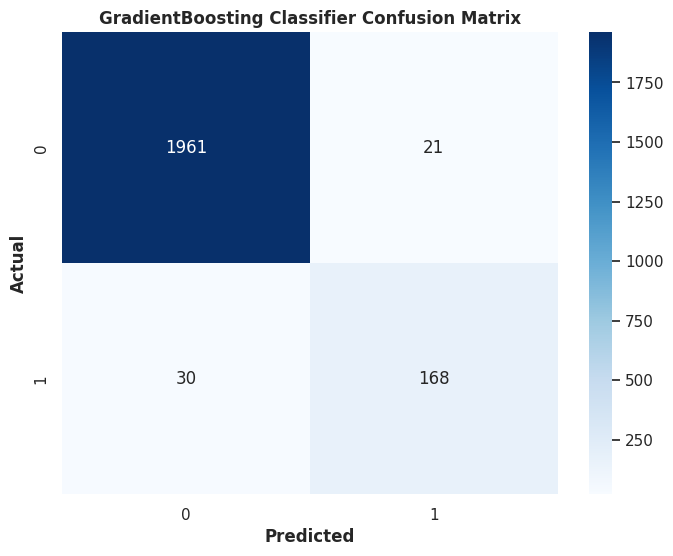


XGBoost Results:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1982
           1       0.76      0.84      0.80       198

    accuracy                           0.96      2180
   macro avg       0.87      0.91      0.89      2180
weighted avg       0.96      0.96      0.96      2180



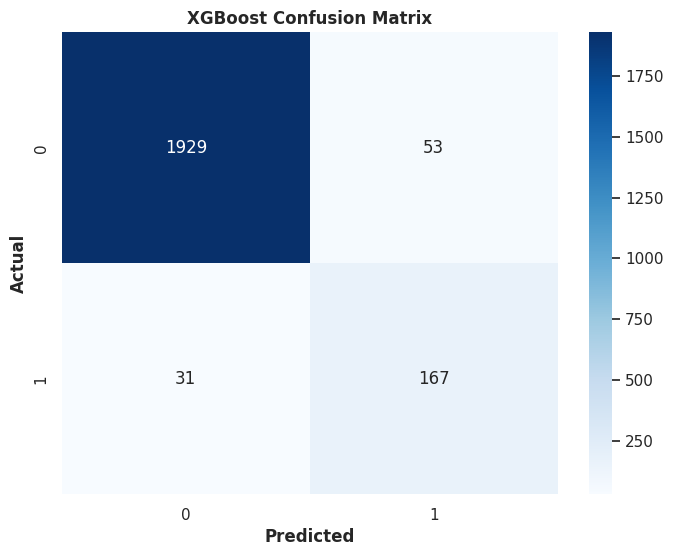


AdaBoost Classifier Results:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1982
           1       0.65      0.86      0.74       198

    accuracy                           0.95      2180
   macro avg       0.82      0.91      0.86      2180
weighted avg       0.96      0.95      0.95      2180



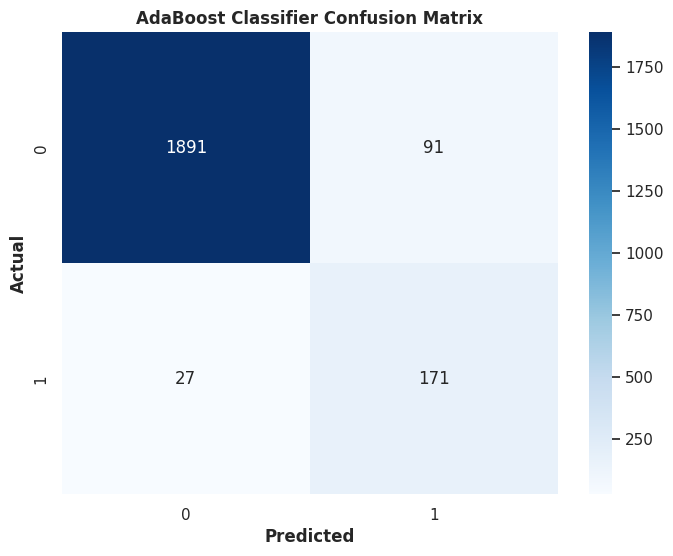


K-Nearest Neighbors Results:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1982
           1       0.57      0.86      0.68       198

    accuracy                           0.93      2180
   macro avg       0.78      0.90      0.82      2180
weighted avg       0.95      0.93      0.93      2180



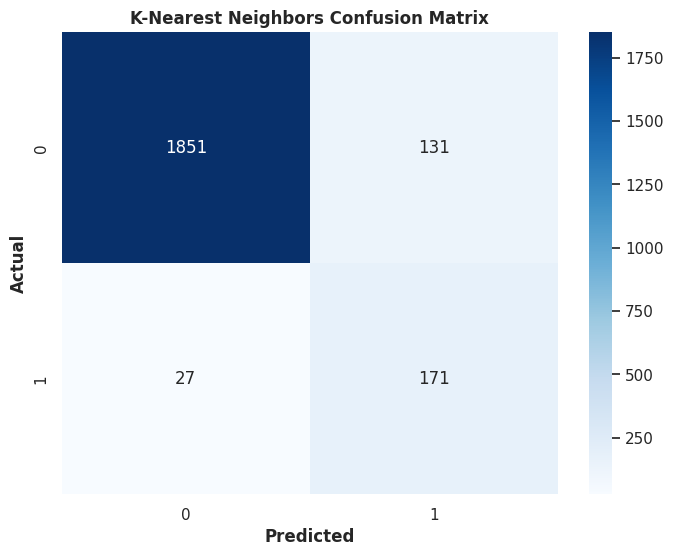


Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1982
           1       0.69      0.85      0.76       198

    accuracy                           0.95      2180
   macro avg       0.84      0.91      0.87      2180
weighted avg       0.96      0.95      0.95      2180



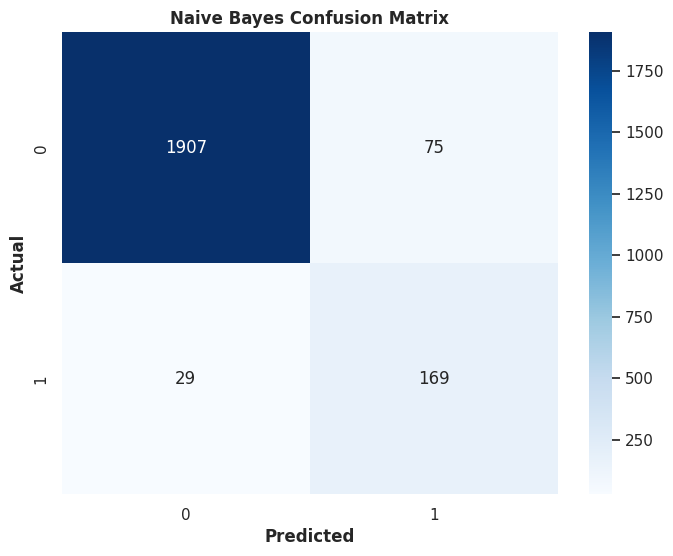


Decision Tree Results:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1982
           1       0.64      0.85      0.73       198

    accuracy                           0.94      2180
   macro avg       0.81      0.90      0.85      2180
weighted avg       0.95      0.94      0.95      2180



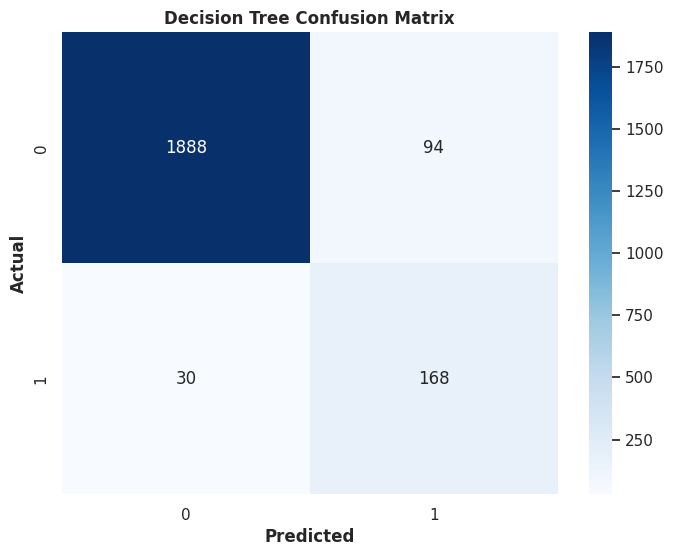


Neural Net Results:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1982
           1       0.68      0.86      0.76       198

    accuracy                           0.95      2180
   macro avg       0.83      0.91      0.87      2180
weighted avg       0.96      0.95      0.95      2180



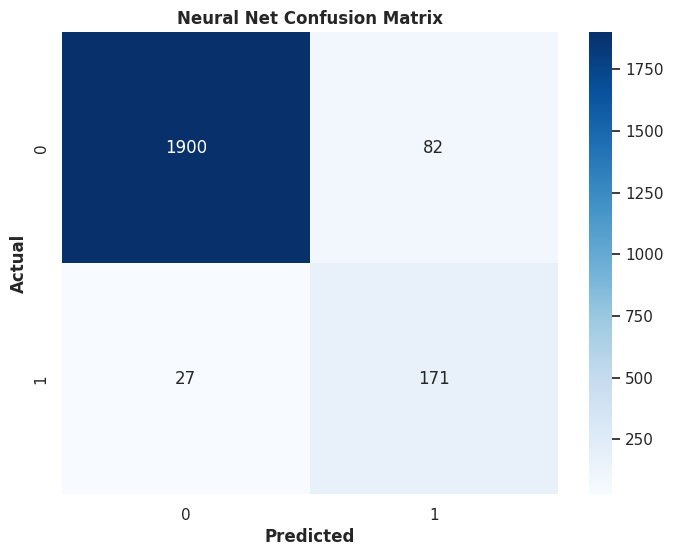


SVM Results:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1982
           1       0.80      0.85      0.82       198

    accuracy                           0.97      2180
   macro avg       0.89      0.91      0.90      2180
weighted avg       0.97      0.97      0.97      2180



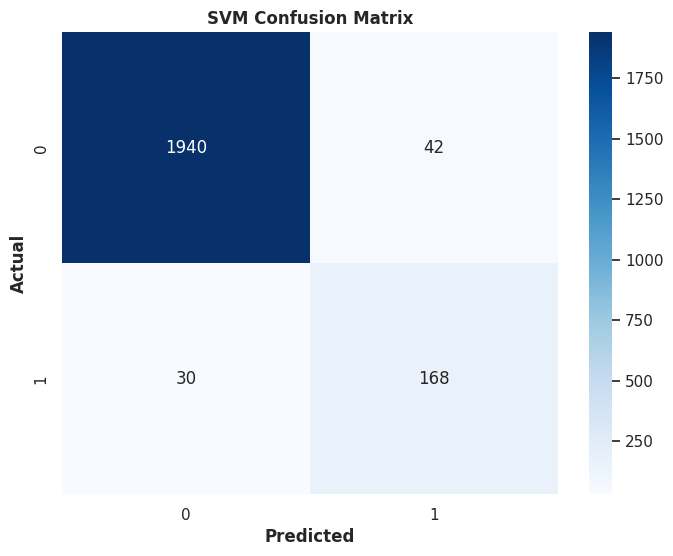

In [32]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    'GradientBoosting Classifier': GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=10),
    'AdaBoost Classifier': AdaBoostClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Neural Net": MLPClassifier(max_iter=500),
    "SVM": SVC(class_weight='balanced')
}

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix", weight='bold')
    plt.xlabel("Predicted", weight='bold')
    plt.ylabel("Actual", weight='bold')
    plt.show();

## 🏆 Best performing Algorithm for Fraud Detection — Summary

After reviewing all 10 models, **Gradient Boosting Classifier** stands out as the best-performing algorithm for fraud detection.

---

### 🔍 Comparison Summary

| Model               | Precision (Class 1) | Recall (Class 1) | F1-score (Class 1) | Accuracy |
|---------------------|---------------------|------------------|--------------------|----------|
| Logistic Regression | 0.69                | 0.86             | 0.77               | 0.95     |
| SVM                 | 0.84                | 0.85             | 0.85               | 0.97     |
| Neural Network      | 0.66                | 0.84             | 0.74               | 0.95     |
| Decision Tree       | 0.64                | 0.84             | 0.73               | 0.94     |
| Naive Bayes         | 0.76                | 0.85             | 0.80               | 0.96     |
| KNN                 | 0.54                | 0.85             | 0.66               | 0.92     |
| AdaBoost            | 0.63                | 0.86             | 0.73               | 0.94     |
| XGBoost             | 0.65                | 0.85             | 0.73               | 0.94     |
| Gradient Boosting   | 0.86                | 0.85             | 0.86               | 0.97     |
| Random Forest       | 0.87                | 0.84             | 0.85               | 0.97     |

---

### 🏆 Recommended Model: **Gradient Boosting Classifier**

#### ✅ Why Gradient Boosting Stands Out:
- **Highest F1-score for fraud class (0.86)** — balances precision and recall effectively.
- **Precision (0.86)** — fewer false positives.
- **Recall (0.85)** — strong fraud detection.
- **Accuracy (0.97)** — excellent overall performance.

---

### 🧪 Close Contenders:
- **Random Forest**: Similar metrics, slightly higher precision but slightly lower recall.
- **SVM**: Strong performance, but slightly lower F1-score than Gradient Boosting.
- **Naive Bayes**: Good balance, but lower precision than ensemble methods.

---

### 📌 Summary

Gradient Boosting offers the **best trade-off between catching fraud (recall)** and **avoiding false alarms (precision)**, making it ideal for high-stakes fraud detection.

If interpretability is a priority, Logistic Regression or Decision Tree may be preferred.  
If performance is key, Gradient Boosting or Random Forest are top choices.



#

## 🔧 Hyperparameter Tuning — Definition

**Hyperparameter tuning** is the process of finding the best set of parameters
for a machine learning model that are not learned directly from the data,
but instead control how the model is trained.
As a result, I focus on fine-tuning two of the previously identified best-performing models: **Logistic Regression** and **Support Vector Machine (SVM)** using `Hyerparameter Tuning`. The goal is to optimize their performance, specifically by maximizing 'recall' for the fraud class, which is crucial in fraud detection to minimize false negatives.


🔍 Tuning Gradient Boosting...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
🔍 Tuning Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

✅ Best Gradient Boosting Model Parameters:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

Classification Report (Gradient Boosting):

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1982
           1       0.99      0.83      0.90       198

    accuracy                           0.98      2180
   macro avg       0.99      0.92      0.95      2180
weighted avg       0.98      0.98      0.98      2180

Gradient Boosting Metrics:
Accuracy : 0.9839449541284404
Precision: 0.9880239520958084
Recall   : 0.8333333333333334
F1-score : 0.9041095890410958

✅ Best Random Forest Model Parameters:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report (Random Forest):

              precision    recall  f1-score   support

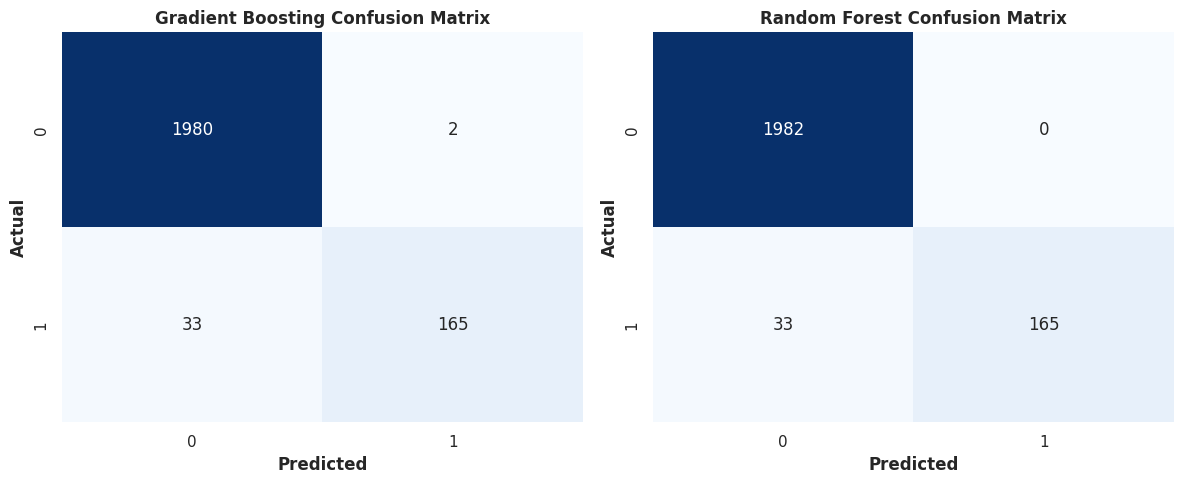

In [34]:
# 1️⃣ Define parameter grids
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# 2️⃣ Initialize models
gb_model = GradientBoostingClassifier()
rf_model = RandomForestClassifier()

# 3️⃣ Setup GridSearchCV
gb_grid = GridSearchCV(gb_model, gb_params, cv=3, scoring='f1', verbose=1, n_jobs=-1)
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='f1', verbose=1, n_jobs=-1)

# 4️⃣ Fit models
print("🔍 Tuning Gradient Boosting...")
gb_grid.fit(X_train, y_train)

print("🔍 Tuning Random Forest...")
rf_grid.fit(X_train, y_train)

# 5️⃣ Best models
gb_best = gb_grid.best_estimator_
rf_best = rf_grid.best_estimator_

y_pred_gb = gb_best.predict(X_test)
y_pred_rf = rf_best.predict(X_test)

# 6️⃣ Print metrics separately
print("\n✅ Best Gradient Boosting Model Parameters:")
print(gb_grid.best_params_)
print("\nClassification Report (Gradient Boosting):\n")
print(classification_report(y_test, y_pred_gb))

print("Gradient Boosting Metrics:")
print("Accuracy :", accuracy_score(y_test, y_pred_gb))
print("Precision:", precision_score(y_test, y_pred_gb))
print("Recall   :", recall_score(y_test, y_pred_gb))
print("F1-score :", f1_score(y_test, y_pred_gb))

print("\n✅ Best Random Forest Model Parameters:")
print(rf_grid.best_params_)
print("\nClassification Report (Random Forest):\n")
print(classification_report(y_test, y_pred_rf))

print("Random Forest Metrics:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1-score :", f1_score(y_test, y_pred_rf))

# 7️⃣ Plot confusion matrices side by side
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title("Gradient Boosting Confusion Matrix", weight='bold')
axes[0].set_xlabel("Predicted", weight='bold')
axes[0].set_ylabel("Actual", weight='bold')

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title("Random Forest Confusion Matrix", weight='bold')
axes[1].set_xlabel("Predicted", weight='bold')
axes[1].set_ylabel("Actual", weight='bold')

plt.tight_layout()
plt.show()


## ✅ Model Summary and Recommendation

Comparing both models:

 Metric       | Gradient Boosting | Random Forest |
|--------------|------------------|---------------|
| **Accuracy** | 0.983            | 0.985         |
| **Precision**| 0.988            | 1.000         |
| **Recall**   | 0.833            | 0.833         |
| **F1-score** | 0.904            | 0.909         |

---
## 🏆 Recommended Model: **Random Forest Classifier**

#### ✅ Why Random Forest Wins:
- Slightly **higher accuracy** and **F1-score** than Gradient Boosting.
- **Perfect precision (1.00)** for fraud class — fewer false positives.
- Same recall (0.83) as Gradient Boosting, meaning equal fraud detection rate.

---

ROC AUC Score: 0.9412235370863019
✅ Best Threshold (based on ROC curve): 0.09

📊 Metrics Comparison Table:
       Threshold  Precision    Recall  F1-score
0  Default (0.5)   1.000000  0.833333  0.909091
1    Best (0.09)   0.611307  0.873737  0.719335


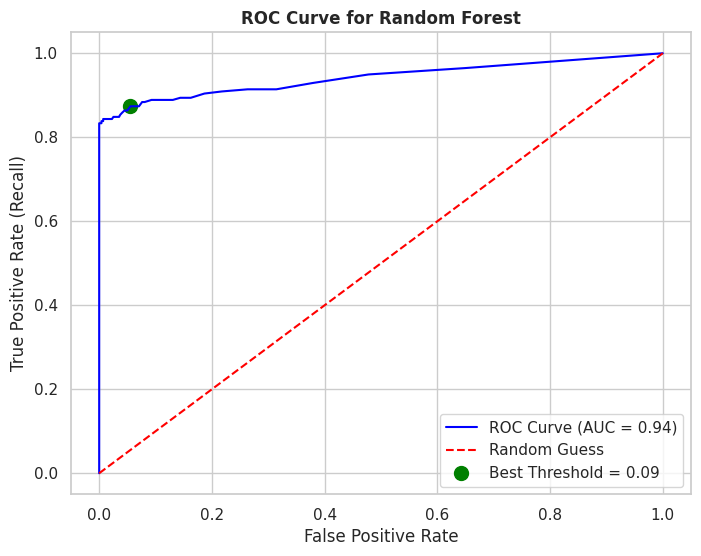

In [35]:
# 📚 Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_score, recall_score, f1_score
)

# ✅ Assume you already have your trained Random Forest model (rf_best)
# and test data (X_test, y_test)

# 1️⃣ Get predicted probabilities for the positive class (fraud class)
y_probs = rf_best.predict_proba(X_test)[:, 1]

# 2️⃣ Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# 3️⃣ Compute AUC (Area Under Curve)
auc_score = roc_auc_score(y_test, y_probs)
print("ROC AUC Score:", auc_score)

# 4️⃣ Find the best threshold (closest to top-left corner)
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
best_index = np.argmin(distances)
best_threshold = thresholds[best_index]
print("✅ Best Threshold (based on ROC curve):", best_threshold)

# 5️⃣ Evaluate metrics at default threshold (0.5)
y_pred_default = (y_probs >= 0.5).astype(int)
precision_default = precision_score(y_test, y_pred_default)
recall_default = recall_score(y_test, y_pred_default)
f1_default = f1_score(y_test, y_pred_default)

# 6️⃣ Evaluate metrics at best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

# 7️⃣ Create summary table
metrics_comparison = pd.DataFrame({
    "Threshold": ["Default (0.5)", f"Best ({best_threshold:.2f})"],
    "Precision": [precision_default, precision_best],
    "Recall": [recall_default, recall_best],
    "F1-score": [f1_default, f1_best]
})

print("\n📊 Metrics Comparison Table:")
print(metrics_comparison)

# 8️⃣ Plot ROC curve with best threshold point
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0,1], [0,1], color='red', linestyle='--', label="Random Guess")
plt.scatter(fpr[best_index], tpr[best_index], color='green', s=100,
            label=f"Best Threshold = {best_threshold:.2f}")
plt.title("ROC Curve for Random Forest", weight='bold')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend()
plt.grid(True)
plt.show()


#

### Saving the Best Trained Model as Pickle for Deployment
The best-trained Random Forest model, along with the defined prediction thresholds are saved to a file. This process is crucial for deploying your model or saving it for future use without having to re-train it every time.

In [38]:
# 📚 Import pickle
import pickle

# ✅ Assume you already have your best Random Forest model (rf_best)
# and you have computed best_threshold from ROC curve tuning

# 1️⃣ Define thresholds
default_threshold = 0.5
best_threshold = best_threshold   # from your ROC curve tuning code

# 2️⃣ Create a dictionary to store everything
model_package = {
    "model": rf_best,
    "default_threshold": default_threshold,
    "best_threshold": best_threshold
}

# 3️⃣ Save the dictionary as a pickle file
with open("/content/drive/MyDrive/NovaPay_Fraud_Predictive_Model/rf_model_with_thresholds.pkl", "wb") as f:
    pickle.dump(model_package, f)

print("✅ Model and thresholds saved successfully as rf_model_with_thresholds.pkl")

# 4️⃣ Load the model and thresholds later
with open("/content/drive/MyDrive/NovaPay_Fraud_Predictive_Model/rf_model_with_thresholds.pkl", "rb") as f:
    loaded_package = pickle.load(f)

print("✅ Model and thresholds loaded successfully")

# Access the model and thresholds
loaded_model = loaded_package["model"]
loaded_default_threshold = loaded_package["default_threshold"]
loaded_best_threshold = loaded_package["best_threshold"]

print("🔍 Loaded thresholds:")
print("Default:", loaded_default_threshold)
print("Best   :", loaded_best_threshold)

# Example prediction using the loaded model and best threshold
y_probs = loaded_model.predict_proba(X_test)[:, 1]
y_pred_best = (y_probs >= loaded_best_threshold).astype(int)


✅ Model and thresholds saved successfully as rf_model_with_thresholds.pkl
✅ Model and thresholds loaded successfully
🔍 Loaded thresholds:
Default: 0.5
Best   : 0.09


#